In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append('../src')
from utils import tiingo_api as tiingo

from pathlib import Path
from collections import defaultdict

plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (15, 5)

DATA_PATH = Path('../scorecard/data')
BASKET_NAME = 'scorecard_single_ticker'
TICKER_PATH = DATA_PATH / '{}.csv'.format(BASKET_NAME)

In [2]:
tickers = pd.read_csv(TICKER_PATH, header=None, names=['Ticker'], squeeze=True)
tickers

0       AAL
1      AAPL
2      ABNB
3      ACIA
4      ADBE
       ... 
160     ZEN
161      ZG
162      ZM
163    ZNGA
164      ZS
Name: Ticker, Length: 165, dtype: object

In [3]:
start = tiingo.DEFAULT_START
end = tiingo.TODAY

price_filename = '_'.join(['prc', BASKET_NAME, start, end, 'Y']) + '.csv'
price_filepath = DATA_PATH / price_filename

if Path(price_filepath).exists():
    print("Found existing price file. Reading...")
    all_prices = pd.read_csv(price_filepath, header=[0,1], index_col=0,
                         parse_dates=True)
    print("Prices read from: ", price_filepath)
else:
    all_prices = tiingo.get_prices(
        tickers, start, end,
        out_path=price_filepath,
        verbose=False)

Found existing price file. Reading...
Prices read from:  ../scorecard/data/prc_scorecard_single_ticker_2005-01-01_2021-02-04_Y.csv


In [4]:
close_prices = all_prices['adjClose']
hi_prices = all_prices['adjHigh']

In [5]:
import strats.threshold_momentum as tm

all_stats = []
last_3y_stats = []
MOVE_THRESHOLDS = [0.02, 0.03, 0.04, 0.05]

for threshold in MOVE_THRESHOLDS:
    returns = tm.threshold_momentum_returns(close_prices, hi_prices, threshold)
    last_3y_returns = tm.threshold_momentum_returns(
        close_prices.last('3Y'), hi_prices.last('3Y'), threshold)
    
    all_stats.extend(tm.calculate_stats(returns, threshold))
    last_3y_stats.extend(
        tm.calculate_stats(last_3y_returns, threshold))

stats_df = pd.DataFrame(all_stats)
last_3y_stats_df = pd.DataFrame(last_3y_stats)

In [6]:
print(f'Stats from {start}')
stats_df.sort_values('sharpe', ascending=False).head(10)

Stats from 2005-01-01


,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
167,ABNB,0.069220,0.03,1.743796,12,12,0,0.039695
332,ABNB,0.068849,0.04,1.654596,11,11,0,0.041611
497,ABNB,0.069975,0.05,1.601820,10,10,0,0.043685
2,ABNB,0.065056,0.02,1.592027,13,13,0,0.040864
602,PING,0.030578,0.05,1.379523,31,28,3,0.022166
272,PING,0.035179,0.03,1.348072,70,67,3,0.026096
288,SNOW,0.054093,0.03,1.325850,20,19,1,0.040798
437,PING,0.033463,0.04,1.294977,51,48,3,0.025840
375,DKNG,0.056229,0.04,1.275543,64,59,5,0.044083
84,MCFE,0.042487,0.02,1.257091,20,19,1,0.033798


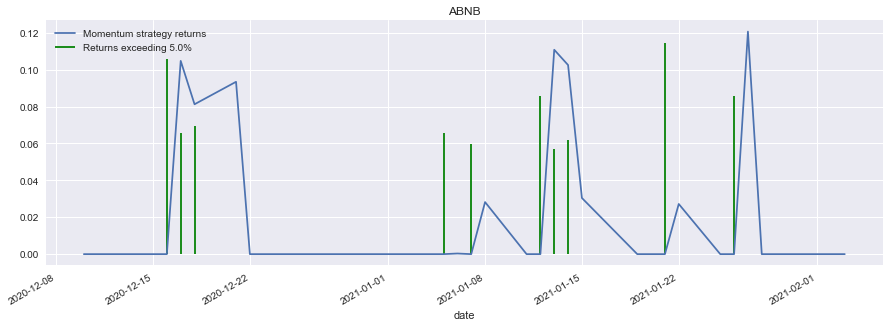

In [13]:
def compare_returns(close_prices, strategy_returns, threshold, ticker):
    ticker_start = close_prices[ticker].first_valid_index()

    close_returns = close_prices[ticker].pct_change()
#     close_returns.plot()
    close_returns = close_returns[close_returns > threshold]
    plt.vlines(
        close_returns.index, 0, close_returns,
        color='green', linestyle='-', label=f'Returns exceeding {threshold * 100}%')
    strategy_returns[ticker].loc[ticker_start:].fillna(0).plot(label='Momentum strategy returns')

    plt.legend()
    plt.title(ticker)
    
compare_returns(close_prices, returns, threshold, 'ABNB')

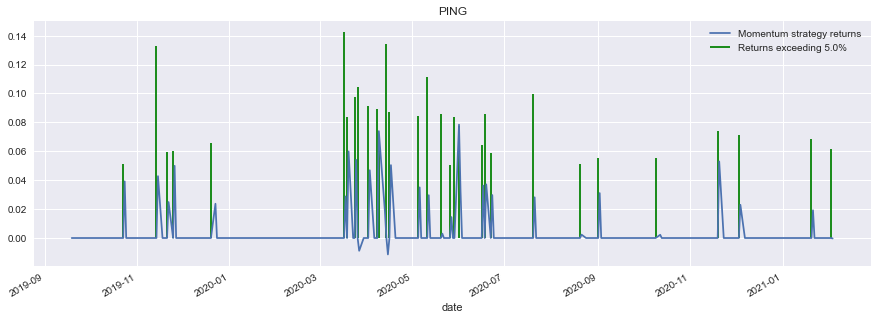

In [14]:
compare_returns(close_prices, returns, threshold, 'PING')

In [17]:
print(f"Stats from {close_prices.last('3Y').index[0].date()}")
last_3y_stats_df.sort_values('Sharpe', ascending=False).head(10)

Stats from 2019-01-02


,Ticker,Mean,Threshold,Sharpe,Count,count_pos,count_neg,Std Dev
167,ABNB,0.069220,0.03,1.743796,12,12,0,0.039695
332,ABNB,0.068849,0.04,1.654596,11,11,0,0.041611
497,ABNB,0.069975,0.05,1.601820,10,10,0,0.043685
2,ABNB,0.065056,0.02,1.592027,13,13,0,0.040864
658,ZNGA,0.039320,0.05,1.569727,9,9,0,0.025049
602,PING,0.030578,0.05,1.379523,31,28,3,0.022166
272,PING,0.035179,0.03,1.348072,70,67,3,0.026096
288,SNOW,0.054093,0.03,1.325850,20,19,1,0.040798
333,ACIA,0.019744,0.04,1.300288,11,11,0,0.015184
437,PING,0.033463,0.04,1.294977,51,48,3,0.025840


In [102]:
# sell_counts = stats_df.loc[stats_df['threshold'] == 0.05, ['ticker', 'count']]
# sell_counts = sell_counts.set_index('ticker')['count']

# random_returns = tm.random_close_to_high_returns(
#     close_prices, hi_prices, default_count=100)
# random_returns.sort_values('sharpe', ascending=False).head(10)

# Evaluating Sharpe values using bootstrap sampling

Let's look at AirBnB for `threshold = 0.05`.

In [90]:
stats_df[(stats_df['ticker'] == 'ABNB')]

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
2,ABNB,0.065056,0.02,1.592027,13,13,0,0.040864
167,ABNB,0.069220,0.03,1.743796,12,12,0,0.039695
332,ABNB,0.068849,0.04,1.654596,11,11,0,0.041611
497,ABNB,0.069975,0.05,1.601820,10,10,0,0.043685


In [72]:
close_to_high = (hi_prices - close_prices.shift()) / close_prices.shift()

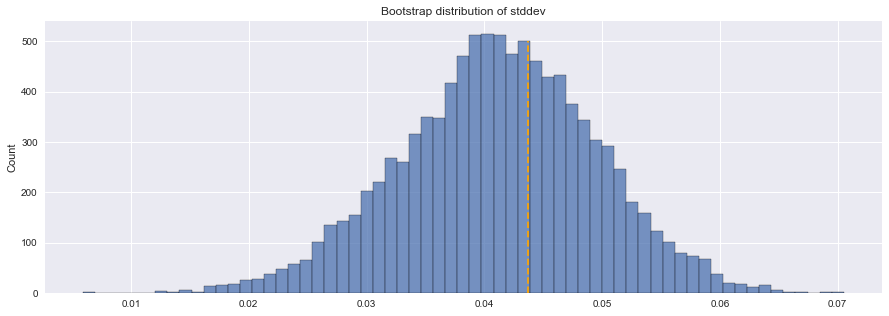

In [104]:
airbnb_stats = stats_df.loc[497]

res = bootstrap(
    close_to_high['ABNB'],
    lambda x: x.std(),
    airbnb_stats['count'], 10000)

sns.histplot(res)
plt.title('Bootstrap distribution of stddev')
plt.vlines(
    [airbnb_stats['std']],
    0, 500, linestyle='--', color='orange')

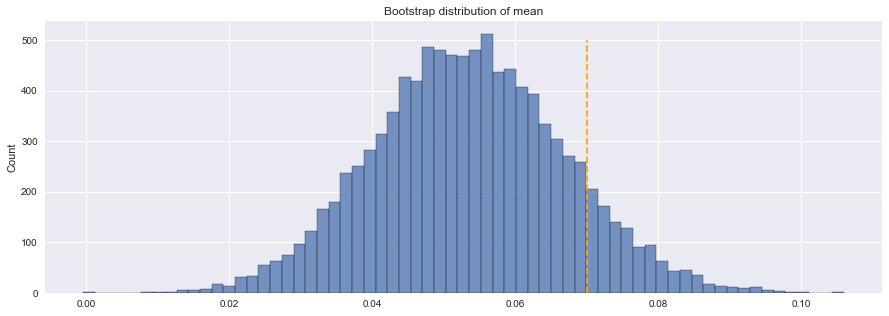

In [96]:
res = bootstrap(
    close_to_high['ABNB'],
    lambda x: x.mean(),
    airbnb_stats['count'], 10000)

sns.histplot(res)
plt.title('Bootstrap distribution of mean')
plt.vlines(
    [airbnb_stats['mean']],
    0, 500, linestyle='--', color='orange')

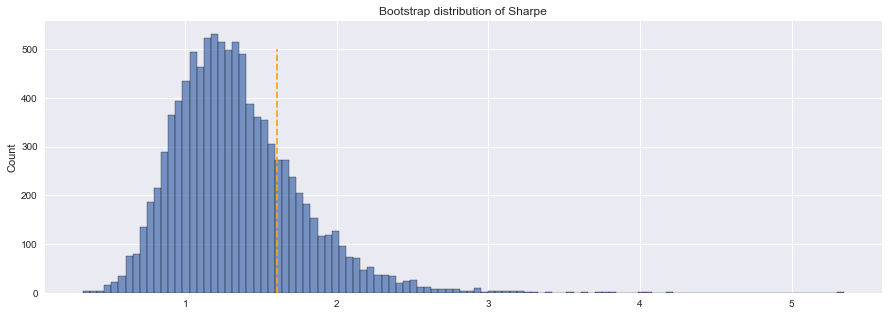

In [105]:
res = bootstrap(
    close_to_high['ABNB'],
    lambda x: x.mean() / x.std(),
    airbnb_stats['count'], 10000)

sns.histplot(res)
plt.title('Bootstrap distribution of Sharpe')
plt.vlines(
    [airbnb_stats['sharpe']],
    0, 500, linestyle='--', color='orange')

In [114]:
np.mean([sharpe > airbnb_stats['sharpe'] for sharpe in res])

0.0

## Returns for limit sells
Work in progress. The return variance is often 0, so Sharpe ratio cannot be applied directly.
Could look at estimates of variance on the sell days as an upper-bound for return variance instead.

In [108]:
all_stats = []
last_3y_stats = []

for threshold in MOVE_THRESHOLDS:
    returns = tm.threshold_momentum_limit_returns(
        close_prices, hi_prices, threshold, 0.01)
    last_3y_returns = tm.threshold_momentum_limit_returns(
        close_prices.last('3Y'), hi_prices.last('3Y'), threshold, 0.01)
    
    all_stats.extend(tm.calculate_stats(returns, threshold))
    last_3y_stats.extend(
        tm.calculate_stats(last_3y_returns, threshold))

stats_df = pd.DataFrame(all_stats)
last_3y_stats_df = pd.DataFrame(last_3y_stats)

../src/strats/threshold_momentum.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  thres_sharpe = thres_mean / thres_std
../src/strats/threshold_momentum.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  thres_sharpe = thres_mean / thres_std
../src/strats/threshold_momentum.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  thres_sharpe = thres_mean / thres_std
../src/strats/threshold_momentum.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  thres_sharpe = thres_mean / thres_std
../src/strats/threshold_momentum.py:67: RuntimeWarning: divide by zero encountered in double_scalars
  thres_sharpe = thres_mean / thres_std


In [67]:
last_3y_stats_df.sort_values('mean', ascending=False).head(10)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
658,ZNGA,0.010000,0.05,inf,9,9,0,0.000000
368,DASH,0.010000,0.04,inf,7,7,0,0.000000
533,DASH,0.010000,0.05,inf,6,6,0,0.000000
2,ABNB,0.009257,0.02,3.454005,13,13,0,0.002680
473,TWLO,0.009236,0.04,4.029166,50,49,1,0.002292
167,ABNB,0.009195,0.03,3.296295,12,12,0,0.002789
638,TWLO,0.009190,0.05,4.503023,33,33,0,0.002041
84,MCFE,0.009145,0.02,3.528087,20,19,1,0.002592
332,ABNB,0.009122,0.04,3.130837,11,11,0,0.002913
115,RXT,0.009084,0.02,3.671326,37,36,1,0.002474


In [109]:
stats_df.sort_values('mean', ascending=False).head(10)

,ticker,mean,threshold,sharpe,count,count_pos,count_neg,std
533,DASH,0.010000,0.05,inf,6,6,0,0.000000
368,DASH,0.010000,0.04,inf,7,7,0,0.000000
2,ABNB,0.009257,0.02,3.454005,13,13,0,0.002680
167,ABNB,0.009195,0.03,3.296295,12,12,0,0.002789
84,MCFE,0.009145,0.02,3.528087,20,19,1,0.002592
332,ABNB,0.009122,0.04,3.130837,11,11,0,0.002913
115,RXT,0.009084,0.02,3.671326,37,36,1,0.002474
280,RXT,0.009060,0.03,3.658228,21,20,1,0.002477
497,ABNB,0.009034,0.05,2.956388,10,10,0,0.003056
517,BILL,0.008941,0.05,3.002469,43,41,2,0.002978


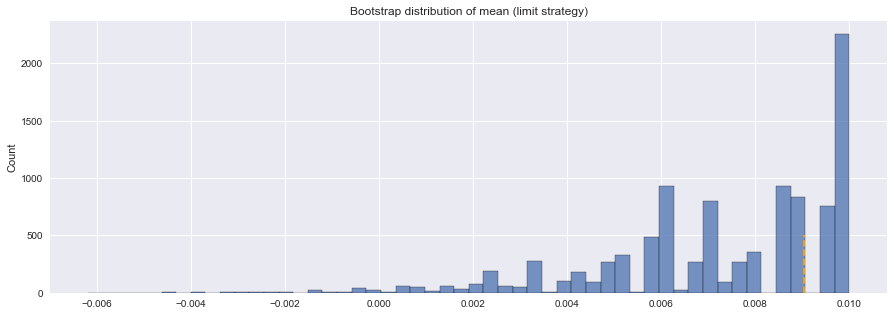

In [111]:
airbnb_stats = stats_df.loc[497]

res = bootstrap(
        np.minimum(0.01, close_to_high['ABNB']),
    lambda x: x.mean(),
    airbnb_stats['count'], 10000)

sns.histplot(res)
plt.title('Bootstrap distribution of mean (limit strategy)')
plt.vlines(
    [airbnb_stats['mean']],
    0, 500, linestyle='--', color='orange')

In [113]:
np.mean([sharpe > stats_df.loc[airbnb_ind, 'mean'] for sharpe in res])

0.301

In [55]:
thres_data_df.to_csv('all_thres_data.csv')
last_three_years_thres_data_df.to_csv('last_three_years_thres_data.csv')